In [ ]:
! pip install pydantic
! pip install PyYAML
! pip install numpy==1.26.4
! pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2
! pip install --no-cache-dir dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dill
!pip install torchdata==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.

In [ ]:
import pandas as pd
import torch
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Graph_Research/filtered_dataset.xlsx')

In [ ]:
df['concept'] = df['concept'].astype(str)
df['paper_id'] = df['paper_id'].astype(str)

## **Loading Vertex Embeddings**

In [ ]:
datadir = '/content/drive/MyDrive/Graph_Research'
max_groupsize = 169
import pickle

# Load the vertex embeddings from the file
with open(datadir + '/vertex_embeddings3_' + str(max_groupsize) + '.p', 'rb') as fp:
    vertex_data = pickle.load(fp)
node_ids = vertex_data["ids"]
node_embeddings = vertex_data["embeddings"]

In [ ]:
with open(datadir + '/hyperedge_embeddings3_' + str(max_groupsize) + '.p', 'rb') as fp:
    hyperedge_data = pickle.load(fp)
hyperedge_ids=hyperedge_data["ids"]
hyperedge_embeddings=hyperedge_data["embeddings"]

In [ ]:
node_embeddings[247].shape

(50,)

## **Incidence Matrix Creation**

In [ ]:
def create_incidence_matrix(df):
  concept_to_idx={word:node_ids.index(word) for word in list(df['concept'].unique())}
  paper_to_idx={str(paper_id):hyperedge_ids.index(paper_id) for paper_id in list(df['paper_id'].unique())}

  rows=[]
  cols=[]
  for _, row in df.iterrows():
    concept_idx=concept_to_idx[row['concept']]
    paper_idx=paper_to_idx[row['paper_id']]
    rows.append(concept_idx)
    cols.append(paper_idx)
  rows=torch.tensor(rows)
  cols=torch.tensor(cols)

  H=dglsp.spmatrix(torch.stack([rows,cols]))
  return H, concept_to_idx

H, concept_to_idx_train = create_incidence_matrix(df)

In [ ]:
H.to_dense()

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## **Positive Samples Generation**

In [ ]:
def generate_positive_samples(df, max_len=16):
    """Generates positive samples (keyword sets that form real hyperedges) from the dataframe."""
    positive_samples = df.groupby('paper_id')['concept'].apply(list).tolist()

    positive_samples_indices = [[node_ids.index(word) if word in node_ids else -1 for word in sublist] for sublist in positive_samples]
    positive_samples_indices = [[word_index for word_index in sample if word_index != -1] for sample in positive_samples_indices]

    #Pad or truncate to ensure consistent length
    padded_samples = []
    for sample in positive_samples_indices:
        if len(sample) < max_len:
            # Pad with zeros
            padded_samples.append(sample + [-1] * (max_len - len(sample))) # Padding with zeros
        elif len(sample) > max_len:
            # Truncate
            padded_samples.append(sample[:max_len])
        else:
            padded_samples.append(sample)

    return torch.tensor(padded_samples, dtype=torch.long)

## **Negative Samples Generation**

In [ ]:
def generate_negative_samples(df, num_samples, max_len=16):

    negative_samples = []
    positive_samples_list = [list(row) for row in df.groupby('paper_id')['concept'].apply(list).tolist()]  # Positive samples as list of lists

    while len(negative_samples) < num_samples:
        # Randomly select a set of keywords and ensure it’s not in positive_samples
        neg_sample_concepts = random.sample(node_ids, random.randint(10,16))
        if neg_sample_concepts not in positive_samples_list:
            # Convert concepts to their indices
            neg_sample_indices = [node_ids.index(word) for word in neg_sample_concepts]

            # Pad or truncate to max_len
            if len(neg_sample_indices) < max_len:
                # Pad with zeros
                neg_sample_indices += [-1] * (max_len - len(neg_sample_indices))
            elif len(neg_sample_indices) > max_len:
                # Truncate to max_len
                neg_sample_indices = neg_sample_indices[:max_len]

            negative_samples.append(neg_sample_indices)

    return torch.tensor(negative_samples, dtype=torch.long)

In [ ]:
import torch
from sklearn.model_selection import train_test_split

def prepare_dataset(positive_samples, negative_samples, test_size=0.2, val_size=0.1):

    # Create labels: 1 for positive samples, 0 for negative samples
    positive_labels = torch.ones(positive_samples.shape[0], dtype=torch.long)
    negative_labels = torch.zeros(negative_samples.shape[0], dtype=torch.long)

    # Concatenate positive and negative samples
    all_samples = torch.cat([positive_samples, negative_samples], dim=0)
    all_labels = torch.cat([positive_labels, negative_labels], dim=0)

    # Shuffle and split into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        all_samples, all_labels, test_size=test_size + val_size, random_state=42, stratify=all_labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=42, stratify=y_temp
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

positive_samples = generate_positive_samples(df)  # Replace `df` with your actual dataframe
negative_samples = generate_negative_samples(df, len(positive_samples))  # Replace with desired number of negatives

X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(positive_samples, negative_samples)

# Print shapes of the datasets
print(f"Train Features: {X_train.shape}, Train Labels: {y_train.shape}")
print(f"Validation Features: {X_val.shape}, Validation Labels: {y_val.shape}")
print(f"Test Features: {X_test.shape}, Test Labels: {y_test.shape}")


Train Features: torch.Size([10677, 16]), Train Labels: torch.Size([10677])
Validation Features: torch.Size([1525, 16]), Validation Labels: torch.Size([1525])
Test Features: torch.Size([3052, 16]), Test Labels: torch.Size([3052])


In [ ]:
import numpy as np

# Example: Assume node_embeddings is a dictionary with node IDs as keys and embeddings as values
# Example structure: node_embeddings = {12: np.array([0.1, 0.2, ..., 0.5]), ...}

def convert_to_embeddings(samples, node_embeddings, embedding_dim):
    """
    Converts node IDs in samples to their corresponding precomputed embeddings.

    Args:
        samples (list of lists): List of samples where each sample is a list of node IDs (including padded values as -1).
        node_embeddings (dict): Dictionary mapping node IDs to their embeddings.
        embedding_dim (int): Dimension of the precomputed embeddings.

    Returns:
        torch.Tensor: Tensor of shape (num_samples, max_len, embedding_dim).
    """
    all_embeddings = []
    for sample in samples:
        embeddings = []
        for node in sample:
            if node == -1:
                # Replace padding (-1) with a zero embedding
                embeddings.append(np.zeros(embedding_dim))
            else:
                # Use the precomputed embedding for the node
                embeddings.append(node_embeddings[node])  # Default to zero embedding if node not found
        all_embeddings.append(embeddings)

    return torch.tensor(all_embeddings, dtype=torch.float)

# Convert positive and negative samples to embedding tensors
positive_embeddings = convert_to_embeddings(positive_samples, node_embeddings, embedding_dim=16)
negative_embeddings = convert_to_embeddings(negative_samples, node_embeddings, embedding_dim=16)

# Concatenate and create labels
X_data = torch.cat((positive_embeddings, negative_embeddings), dim=0)
y_data = torch.cat((torch.ones(len(positive_embeddings)), torch.zeros(len(negative_embeddings))), dim=0)


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)


In [ ]:
class HyperedgeLinkPredictor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        """
        Initialize the model.

        Args:
            embedding_dim (int): Dimension of the precomputed node embeddings.
            hidden_dim (int): Dimension of the hidden layer.
        """
        super(HyperedgeLinkPredictor, self).__init__()
        # Fully connected layers for prediction
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output layer for binary classification

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, max_len, embedding_dim),
                              where each row is the set of node embeddings in a hyperedge.

        Returns:
            torch.Tensor: Predicted probabilities for each input hyperedge.
        """
        # Aggregate embeddings using mean pooling
        x_pooled = torch.mean(x, dim=1)  # Shape: (batch_size, embedding_dim)

        # Fully connected layers
        x_hidden = F.relu(self.fc1(x_pooled))  # Shape: (batch_size, hidden_dim)
        logits = self.fc2(x_hidden)  # Shape: (batch_size, 1)

        return torch.sigmoid(logits).squeeze()  # Output probabilities (Shape: batch_size)


Epoch 1/150, Train Loss: 0.2532, Val Loss: 0.2688
Epoch 2/150, Train Loss: 0.2515, Val Loss: 0.2738
Epoch 3/150, Train Loss: 0.2478, Val Loss: 0.2664
Epoch 4/150, Train Loss: 0.2467, Val Loss: 0.2707
Epoch 5/150, Train Loss: 0.2448, Val Loss: 0.2696
Epoch 6/150, Train Loss: 0.2445, Val Loss: 0.2682
Epoch 7/150, Train Loss: 0.2427, Val Loss: 0.2666
Epoch 8/150, Train Loss: 0.2420, Val Loss: 0.2670
Epoch 9/150, Train Loss: 0.2422, Val Loss: 0.2665
Epoch 10/150, Train Loss: 0.2411, Val Loss: 0.2653
Epoch 11/150, Train Loss: 0.2400, Val Loss: 0.2692
Epoch 12/150, Train Loss: 0.2399, Val Loss: 0.2651
Epoch 13/150, Train Loss: 0.2391, Val Loss: 0.2802
Epoch 14/150, Train Loss: 0.2391, Val Loss: 0.2687
Epoch 15/150, Train Loss: 0.2387, Val Loss: 0.2662
Epoch 16/150, Train Loss: 0.2386, Val Loss: 0.2671
Epoch 17/150, Train Loss: 0.2377, Val Loss: 0.2636
Epoch 18/150, Train Loss: 0.2371, Val Loss: 0.2667
Epoch 19/150, Train Loss: 0.2362, Val Loss: 0.2760
Epoch 20/150, Train Loss: 0.2381, Val Lo

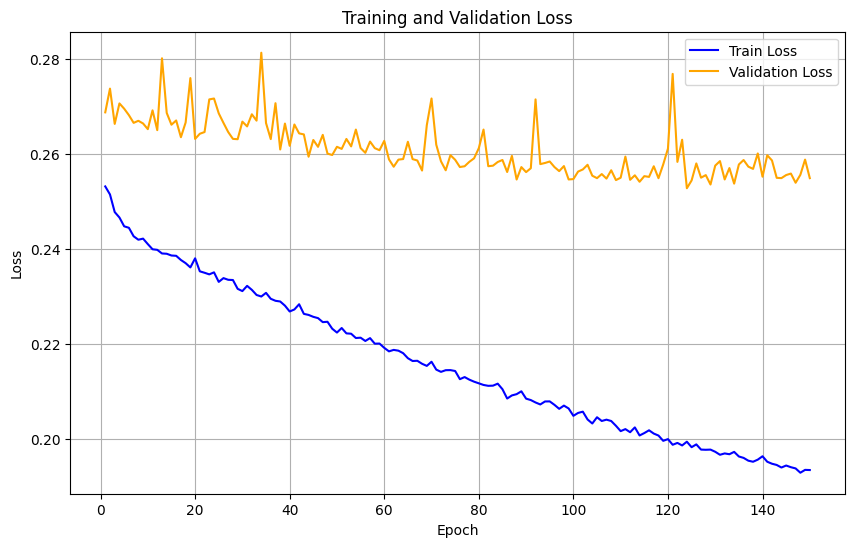

In [ ]:
import matplotlib.pyplot as plt

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y.float())
            val_loss += loss.item()

    # Store losses
    train_losses.append(total_loss / len(train_loader))  # Average training loss
    val_losses.append(val_loss / len(val_loader))  # Average validation loss

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Accuracy: 0.9048
Precision: 0.9189
Recall: 0.8827
F1 Score: 0.9005

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      1172
         1.0       0.92      0.88      0.90      1117

    accuracy                           0.90      2289
   macro avg       0.91      0.90      0.90      2289
weighted avg       0.91      0.90      0.90      2289



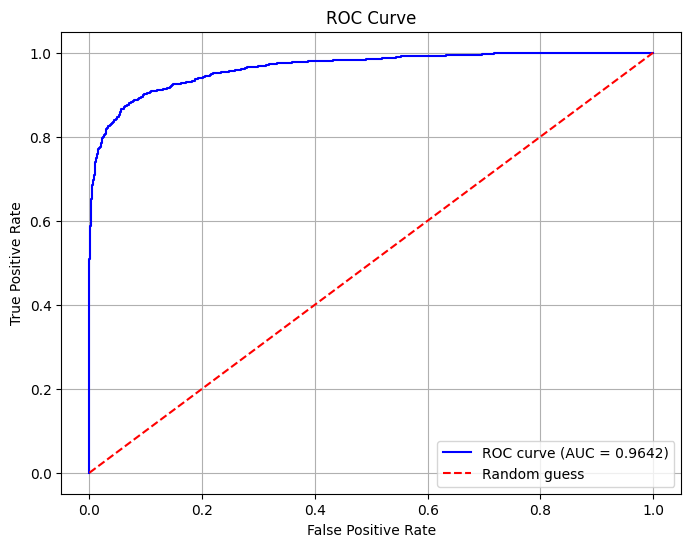

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            predicted_labels = (predictions > 0.5).long()
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probabilities.extend(predictions.cpu().numpy())  # For ROC curve

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", report)

    # ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Evaluate the model
evaluate_model(model, test_loader)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            predicted_labels = (predictions > 0.5).long()
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

evaluate_model(model, test_loader)


Accuracy: 0.9048
Precision: 0.9189
Recall: 0.8827
F1 Score: 0.9005
